# MMX Walkthrough

## Reading libraries and dataset

In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score

dataset = pd.read_csv("D:/Github_projects/MMX/Sample_Media_Spend_Data.csv").set_index("Calendar_Week")
dataset.index = pd.to_datetime(dataset.index)

## Understanding the variables

In [233]:
print(dataset.columns)
print(dataset.describe())
dataset

Index(['Division', 'Paid_Views', 'Organic_Views', 'Google_Impressions',
       'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions',
       'Overall_Views', 'Sales'],
      dtype='object')
          Paid_Views  Organic_Views  Google_Impressions  Email_Impressions  \
count    3051.000000    3051.000000        3.051000e+03       3.051000e+03   
mean    15093.941658   13355.673222        8.861738e+05       7.605094e+05   
std     30785.884979   24079.399689        1.355076e+06       6.260141e+05   
min         1.000000       1.000000        7.000000e+00       4.089445e+04   
25%       537.000000     712.500000        1.698280e+05       3.784969e+05   
50%      2699.000000    4110.000000        4.905310e+05       5.909708e+05   
75%     17358.000000   16230.500000        1.022622e+06       9.622466e+05   
max    518190.000000  270453.000000        1.715044e+07       7.317730e+06   

       Facebook_Impressions  Affiliate_Impressions  Overall_Views  \
count          3.051000

,Division,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
Calendar_Week,,,,,,,,,
2018-01-06,A,392,422,408,3.498950e+05,73580,12072,682,59417
2018-01-13,A,787,904,110,5.062702e+05,11804,9499,853,56806
2018-01-20,A,81,970,742,4.300422e+05,52232,17048,759,48715
2018-01-27,A,25,575,65,4.177457e+05,78640,10207,942,72047
2018-02-03,A,565,284,295,4.085058e+05,40561,5834,658,56235
...,...,...,...,...,...,...,...,...,...
2020-02-01,Z,29239,25311,622406,1.459071e+06,45026,12098,53667,82707
2020-02-08,Z,26230,28031,624409,5.342505e+05,227070,9548,53665,84503
2020-02-15,Z,24749,31281,439362,4.227182e+05,393685,9861,55561,147325


## EDA

<AxesSubplot:>

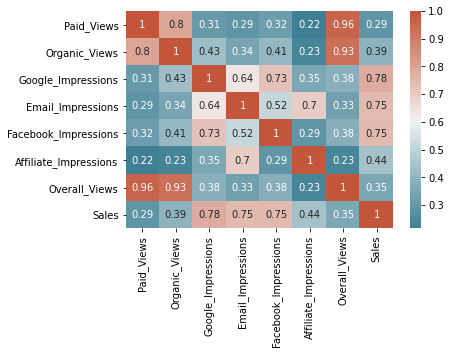

In [29]:
corr=dataset.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

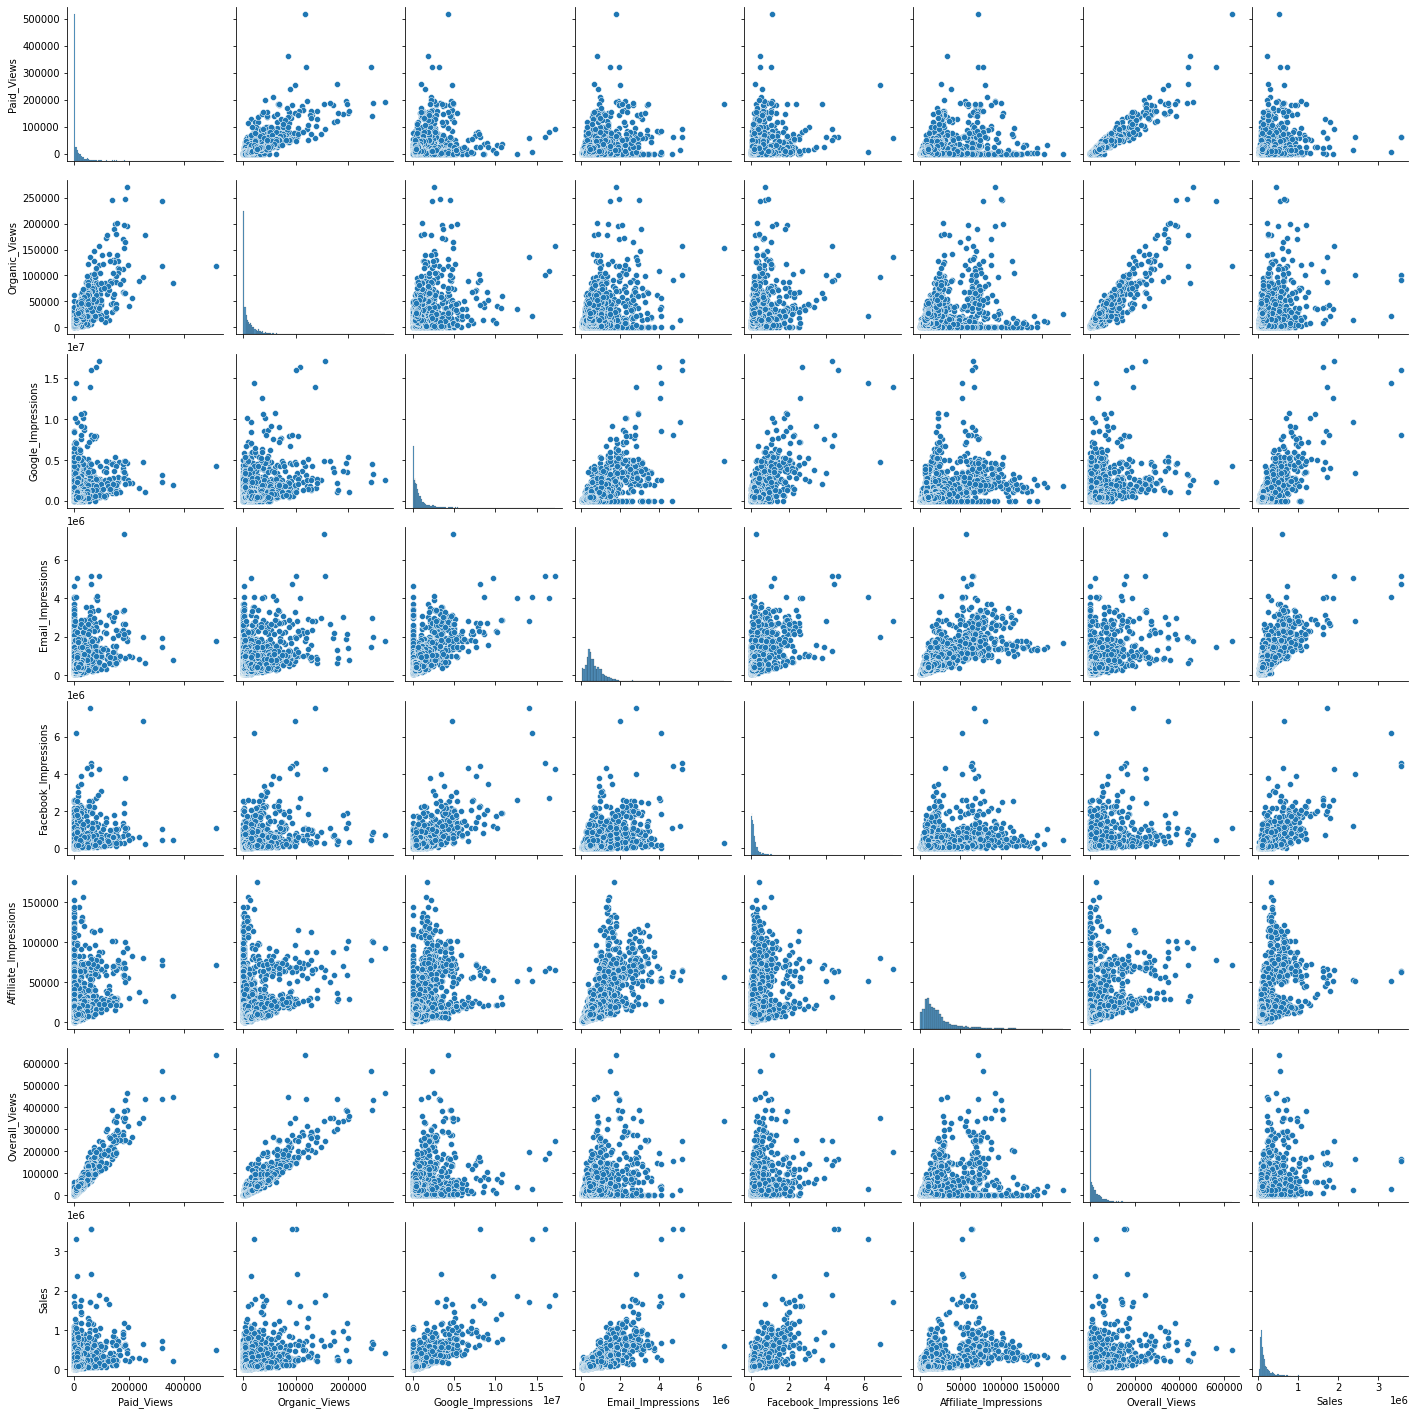

In [10]:
sns.pairplot(dataset)

## Building the OLS model

### Building a function for data transformations

In [234]:
# Post EDA, lets start off by building functions for data transformations before we build the actual model
def data_transforms(adstock=0.0, lag=0, variable_data = pd.Series()):
    variable_data = variable_data.shift(int(lag)).fillna(0)
    variable_data_adstock = []
    for i in range(len(variable_data)):
        if i==0:
            variable_data_adstock.append(variable_data[i])
        else:
            variable_data_adstock.append(np.floor(variable_data[i] + adstock*variable_data_adstock[i-1]))
    return pd.Series(variable_data_adstock, index = variable_data.index)

c:\users\tanya\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [235]:
# Creating a new dataframe to keep the original intact
new_dataframe=pd.DataFrame()
new_dataframe["Sales"] = dataset["Sales"].copy()

### Applying the data transforms to the variables

In [236]:
new_dataframe["Paid_Views"] = data_transforms(adstock = 0, lag = 0, variable_data = dataset["Paid_Views"])
new_dataframe["Organic_Views"] = data_transforms(adstock = 0, lag = 0, variable_data = dataset["Organic_Views"])
new_dataframe["Google_Impressions"] = data_transforms(adstock = 0, lag = 0, variable_data = dataset["Google_Impressions"])
new_dataframe["Email_Impressions"] = data_transforms(adstock = 0, lag = 0, variable_data = dataset["Email_Impressions"])
new_dataframe["Facebook_Impressions"] = data_transforms(adstock = 0, lag = 0, variable_data = dataset["Facebook_Impressions"])
new_dataframe["Affiliate_Impressions"] = data_transforms(adstock = 0, lag = 0, variable_data = dataset["Affiliate_Impressions"])
new_dataframe["Overall_Views"] = data_transforms(adstock = 0, lag = 0, variable_data = dataset["Overall_Views"])

new_dataframe

,Sales,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views
Calendar_Week,,,,,,,,
2018-01-06,59417,392.0,422.0,408.0,3.498950e+05,73580.0,12072.0,682.0
2018-01-13,56806,787.0,904.0,110.0,5.062700e+05,11804.0,9499.0,853.0
2018-01-20,48715,81.0,970.0,742.0,4.300420e+05,52232.0,17048.0,759.0
2018-01-27,72047,25.0,575.0,65.0,4.177450e+05,78640.0,10207.0,942.0
2018-02-03,56235,565.0,284.0,295.0,4.085050e+05,40561.0,5834.0,658.0
...,...,...,...,...,...,...,...,...
2020-02-01,82707,29239.0,25311.0,622406.0,1.459071e+06,45026.0,12098.0,53667.0
2020-02-08,84503,26230.0,28031.0,624409.0,5.342500e+05,227070.0,9548.0,53665.0
2020-02-15,147325,24749.0,31281.0,439362.0,4.227180e+05,393685.0,9861.0,55561.0


### Log transforming the data 

In [237]:
new_dataframe = np.log(new_dataframe)
new_dataframe[new_dataframe == -np.inf] = 0

### Splitting the data in test, train and also as dependent and independent

In [238]:
y = new_dataframe[["Sales"]]
x = new_dataframe.loc[:, new_dataframe.columns != "Sales"]

x = sm.add_constant(x) #adding constant to the model

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 200)

### Model Build

In [239]:
mmm_model = sm.OLS(y_train, x_train)
model_output = mmm_model.fit()
model_result = (model_output.summary2().tables[1])
model_output.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:               OLS               Adj. R-squared:      0.714    
Dependent Variable:  Sales             AIC:                 2574.8096
Date:                2021-09-25 15:54  BIC:                 2620.6931
No. Observations:    2288              Log-Likelihood:      -1279.4  
Df Model:            7                 F-statistic:         817.6    
Df Residuals:        2280              Prob (F-statistic):  0.00     
R-squared:           0.715             Scale:               0.17978  
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.7869   0.1605  4.9030 0.0000  0.4722  1.1016
Paid_Views            -0.0467   0.0086 -5.4523 0.0000 -0.0634 -0.0299
Organic_Views          0.0487   0.0110  4.4468 0.0000  0.0273  0.0702
Google_Impressions    -0.0200   0.0035 -5.6407 0.0000 -0.0270 -0.0131
Email_Impressions      0.7764   0.0231 33.6018 0.0000  0.7311  0.8217
Facebook_Impressions   0.2025   0.0090 22.4254 0.0000  0.1848  0.2202
Affiliate_Impressions -0.1794   0.0191 -9.3968 0.0000 -0.2169 -0.1420
Overall_Views          0.0305   0.0114  2.6728 0.0076  0.0081  0.0528
---------------------------------------------------------------------
Omnibus:              241.524        Durbin-Watson:           1.939  
Prob(Omnibus):        0.000          Jarque-Bera (JB):        362.344
Skew:                 0.779          Prob(JB):                0.000  
Kurtosis:             4.171          Condition No.:           504    
=====================================================================

"""

### Predicting

In [240]:
y_train["y_predict"] = model_output.predict(x_train)
y_test["y_predict"] = model_output.predict(x_test)

c:\users\tanya\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\tanya\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [241]:
y_test

,Sales,y_predict
Calendar_Week,,
2018-10-13,12.271968,12.006847
2018-12-22,11.565774,11.318039
2019-11-09,12.805664,12.817894
2019-07-27,11.666427,12.064319
2018-08-04,12.753919,12.060455
...,...,...
2019-06-29,11.047726,11.436646
2019-06-22,10.219866,10.506036
2018-09-29,11.252729,11.340037


### Measuring model performance

#### R2 measurement

In [242]:
# test and train mape
# train
r2_score(y_train["Sales"],y_train.y_predict)

0.7151216535546701

In [243]:
# test
r2_score(y_test["Sales"],y_test.y_predict)

0.7061544993783844

#### MAPE measurement

In [244]:
# train
np.mean(np.abs((np.exp(y_train["Sales"]) - np.exp(y_train.y_predict)) / np.exp(y_train["Sales"])))

0.33195758707819245

In [245]:
# test
np.mean(np.abs((np.exp(y_test["Sales"]) - np.exp(y_test.y_predict)) / np.exp(y_test["Sales"])))

0.3221901928364319

### Calculating contribution from model

In [246]:
output_table = x_test.copy()
output_table = output_table * model_output.params.T #multiplying with beta coeffs
output_table["factor"] = output_table.sum(axis=1)
output_table

,const,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,factor
Calendar_Week,,,,,,,,,
2018-10-13,0.78691,-0.252458,0.383748,-0.281896,10.456062,2.458084,-1.784673,0.241070,12.006847
2018-12-22,0.78691,-0.389122,0.396923,-0.243954,9.967458,2.126999,-1.594222,0.267046,11.318039
2019-11-09,0.78691,-0.464570,0.510737,-0.312361,11.020857,2.729894,-1.786521,0.332948,12.817894
2019-07-27,0.78691,-0.513396,0.544216,-0.277462,10.361861,2.593503,-1.790036,0.358724,12.064319
2018-08-04,0.78691,-0.287915,0.326286,-0.284189,10.811468,2.596581,-2.097361,0.208675,12.060455
...,...,...,...,...,...,...,...,...,...
2019-06-29,0.78691,-0.461588,0.464852,-0.256985,9.912728,2.254638,-1.580778,0.316870,11.436646
2019-06-22,0.78691,-0.402177,0.419833,-0.221379,9.075608,2.159411,-1.592724,0.280553,10.506036
2018-09-29,0.78691,-0.309999,0.319142,-0.261893,9.779508,2.448025,-1.618918,0.197261,11.340037


In [247]:
factor = np.exp(output_table["factor"]/output_table["factor"])

In [248]:
output_table.drop(["factor"],axis = 1,inplace = True)
output_table = output_table.multiply(factor, axis = 0)

In [249]:
output_table

,const,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views
Calendar_Week,,,,,,,,
2018-10-13,2.139043,-0.686251,1.043134,-0.766272,28.422524,6.681765,-4.851243,0.655295
2018-12-22,2.139043,-1.057744,1.078949,-0.663135,27.094360,5.781782,-4.333544,0.725906
2019-11-09,2.139043,-1.262831,1.388326,-0.849085,29.957795,7.420622,-4.856267,0.905046
2019-07-27,2.139043,-1.395554,1.479331,-0.754221,28.166458,7.049872,-4.865823,0.975112
2018-08-04,2.139043,-0.782633,0.886937,-0.772506,29.388617,7.058240,-5.701219,0.567239
...,...,...,...,...,...,...,...,...
2019-06-29,2.139043,-1.254728,1.263598,-0.698558,26.945588,6.128740,-4.297001,0.861343
2019-06-22,2.139043,-1.093231,1.141225,-0.601770,24.670061,5.869887,-4.329472,0.762623
2018-09-29,2.139043,-0.842664,0.867519,-0.711900,26.583459,6.654422,-4.400675,0.536211


In [250]:
output_table = output_table.T.sum(axis = 1)
print(output_table)

const                     1632.089907
Paid_Views                -756.564829
Organic_Views              816.858572
Google_Impressions        -496.685941
Email_Impressions        21361.604433
Facebook_Impressions      4906.765394
Affiliate_Impressions    -3600.081553
Overall_Views              536.119009
dtype: float64


In [251]:
model_result["Sales_contri"] = output_table
model_result["Sales_contri_perc"] = 100 * model_result["Sales_contri"]/model_result["Sales_contri"].sum()
model_result

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],Sales_contri,Sales_contri_perc
const,0.786910,0.160495,4.903032,1.010177e-06,0.472179,1.101641,1632.089907,6.688864
Paid_Views,-0.046651,0.008556,-5.452338,5.507548e-08,-0.063429,-0.029872,-756.564829,-3.100662
Organic_Views,0.048748,0.010962,4.446835,9.132624e-06,0.027251,0.070245,816.858572,3.347767
Google_Impressions,-0.020010,0.003547,-5.640651,1.904011e-08,-0.026967,-0.013054,-496.685941,-2.035589
Email_Impressions,0.776414,0.023106,33.601773,2.004236e-201,0.731102,0.821726,21361.604433,87.547182
Facebook_Impressions,0.202475,0.009029,22.425376,8.174870e-101,0.184770,0.220181,4906.765394,20.109608
Affiliate_Impressions,-0.179442,0.019096,-9.396752,1.319696e-20,-0.216890,-0.141994,-3600.081553,-14.754369
Overall_Views,0.030463,0.011397,2.672827,7.575102e-03,0.008113,0.052813,536.119009,2.197200
